<a href="https://colab.research.google.com/github/tringuyen2/3DObjectDetection/blob/main/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2811, done.
remote: Counting objects: 100% (2811/2811), done.
remote: Compressing objects: 100% (2347/2347), done.
remote: Total 2811 (delta 721), reused 1320 (delta 428), pack-reused 0
Receiving objects: 100% (2811/2811), 32.80 MiB | 6.79 MiB/s, done.
Resolving deltas: 100% (721/721), done.


In [2]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1660323 sha256=bfa8312b2ad9ae8c8aa40f8bba04c4267ad6f484538d71eb1f74fa85327a8821
  Stored in directory: /tmp/pip-ephem-wheel-cache-21u5n4ja/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=3bff3ba693f8084e45da610ef790b1efae2506940f8140a2c19d8dfd70d1c0b0
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=f799cb2113404122c915e157eaa5223513670cdc1c5995a1e1484226312a3f40
  Stored in directory: /root/.cache



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

tf.get_logger().setLevel('ERROR')

%matplotlib inline

In [22]:
def load_image_into_numpy_array(path):
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = (image.size)
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

TEST_IMAGES = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # By 663highland, Source: https://commons.wikimedia.org/wiki/File:Kitano_Street_Kobe01s5s4110.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg',
  'Street2' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Jln_Toa_Payoh_bef_Kim_Keat_20060402.JPG/1200px-Jln_Toa_Payoh_bef_Kim_Keat_20060402.JPG'
}


In [5]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [6]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


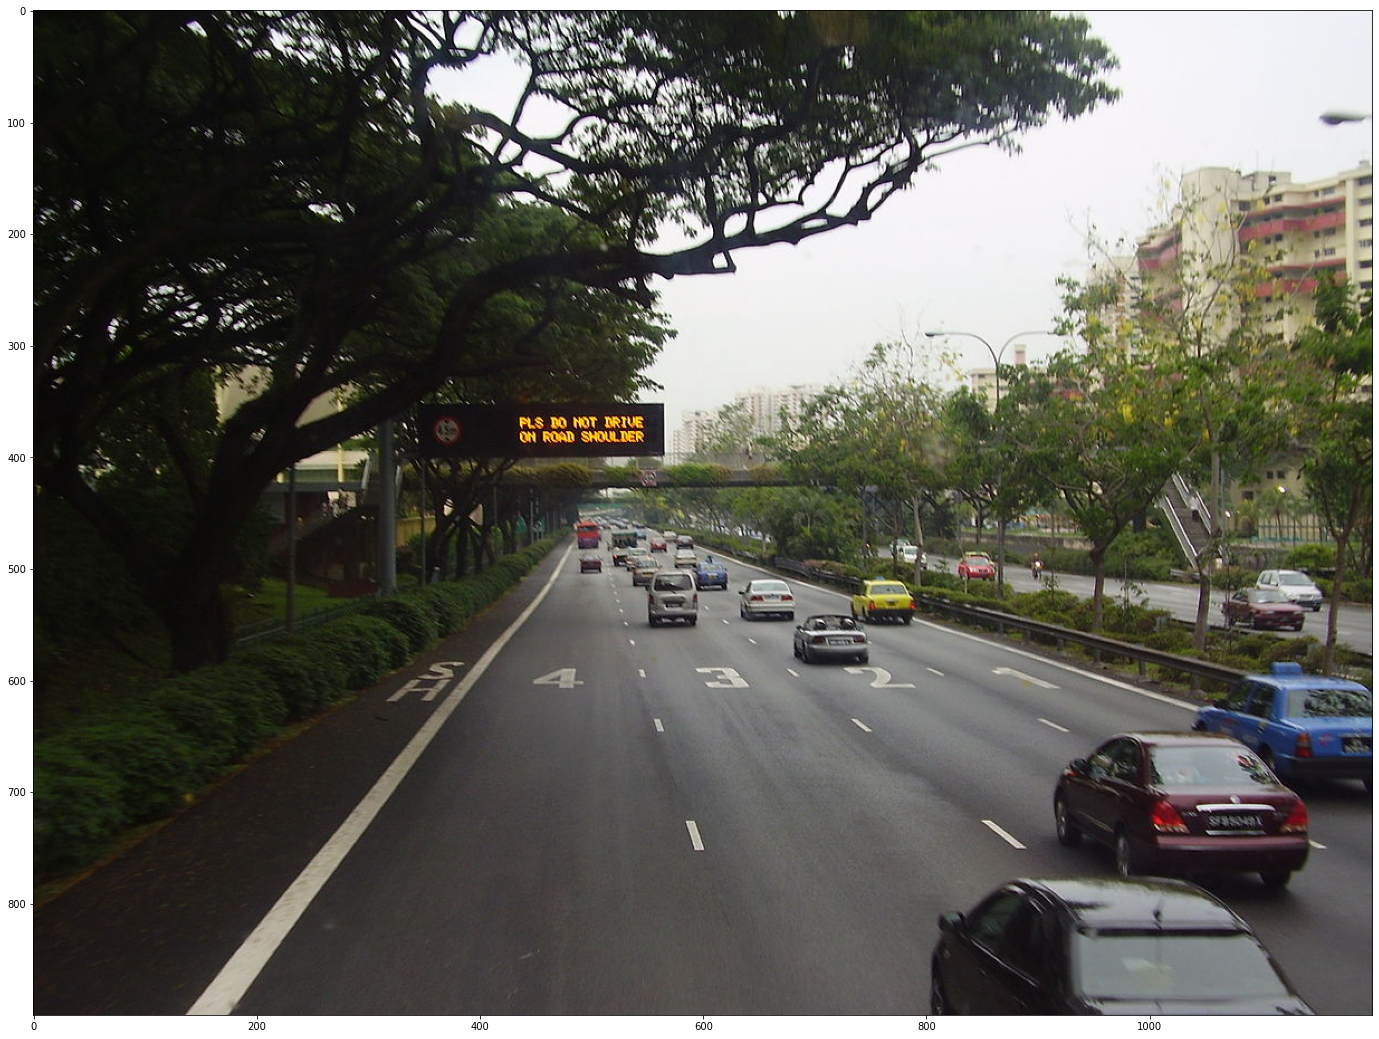

In [23]:
image_path = TEST_IMAGES['Street2']

image_np = load_image_into_numpy_array(image_path)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [24]:
results = hub_model(image_np)


In [25]:
result = {key: value.numpy() for key, value in results.items()}

for key in result.keys():
  print(key)

num_detections
proposal_boxes
detection_anchor_indices
proposal_boxes_normalized
box_classifier_features
detection_multiclass_scores
refined_box_encodings
anchors
mask_predictions
final_anchors
raw_detection_boxes
image_shape
rpn_features_to_crop
rpn_objectness_predictions_with_background
class_predictions_with_background
detection_boxes
detection_classes
detection_masks
rpn_box_encodings
rpn_box_predictor_features
num_proposals
detection_scores
raw_detection_scores


In [26]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [27]:
print(category_index[1])
print(category_index[2])
print(category_index[4])

{'id': 1, 'name': 'person'}
{'id': 2, 'name': 'bicycle'}
{'id': 4, 'name': 'motorcycle'}


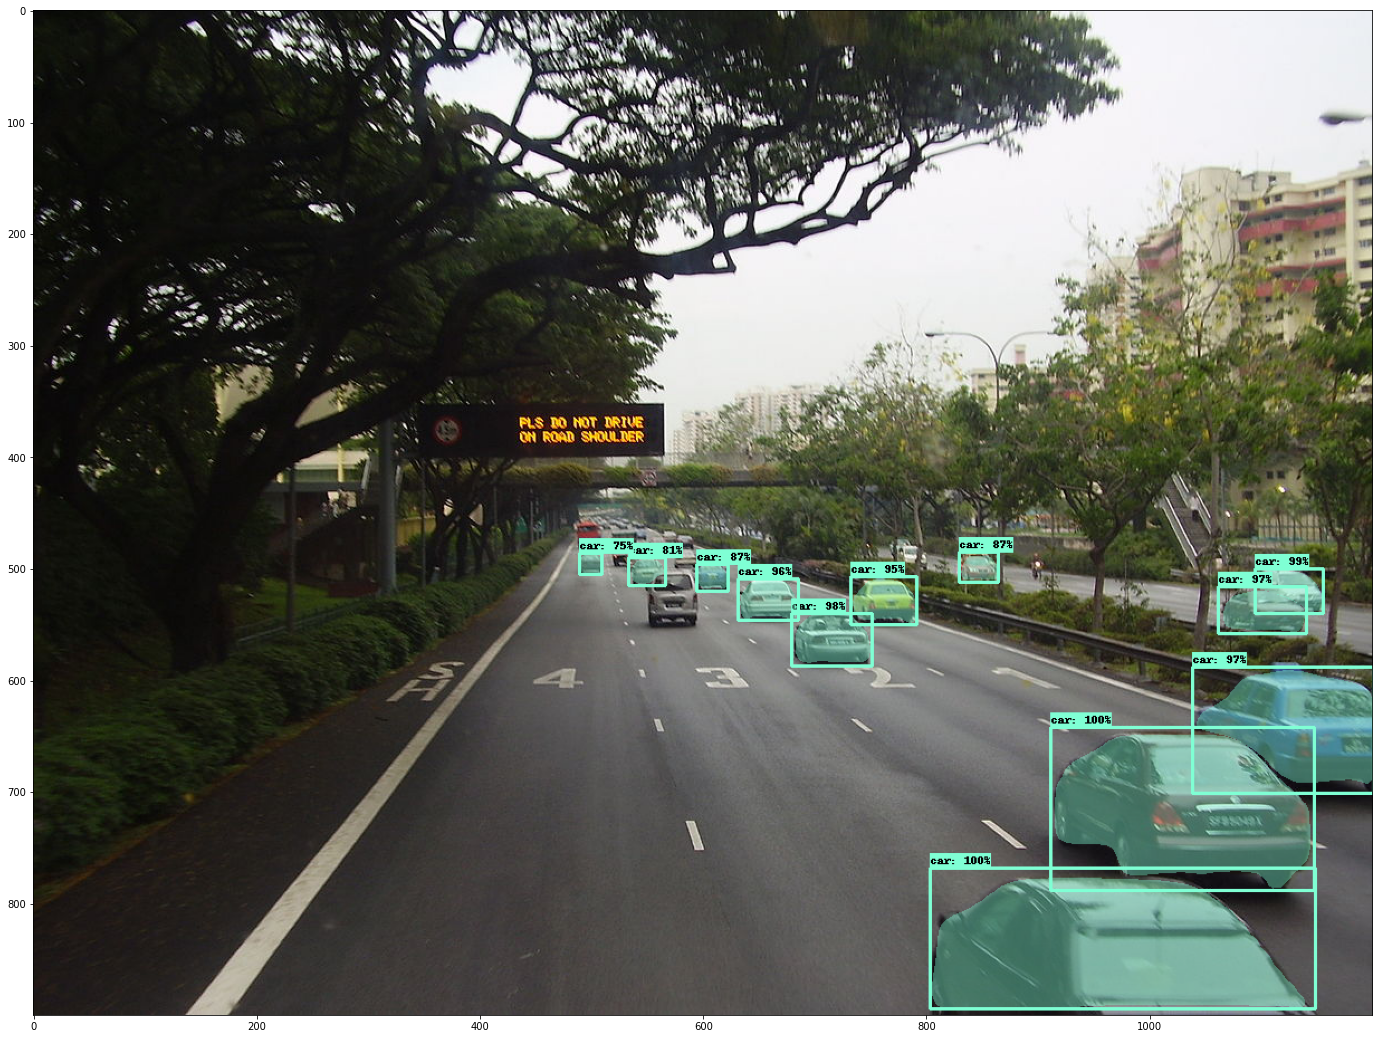

In [29]:
label_id_offset = 0
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(results['detection_boxes'][0])

  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image_np.shape[1], image_np.shape[2])

  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.6, tf.uint8)

  result['detection_masks_reframed'] = detection_masks_reframed.numpy()


viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_mask[0],
    result['detection_boxes'][0],
    (result['detection_classes'][0] + label_id_offset).astype(int),
    result['detection_scores'][0],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=100,
    min_score_thresh=.70,
    agnostic_mode=False,
    instance_masks=result.get('detection_masks_reframed', None),
    line_thickness=3
)

plt.figure(figsize=(24, 32))
plt.imshow(image_np_with_mask[0])
plt.show()